# ELEC 400M / EECE 571M Assignment 1: Linear models for classification
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will be using linear models discussed in the lectures to perform a binary classification task. You will compare the performances of linear classification and logistic regression using suitable training algorithms. The implementation will be done in python using functions from the NumPy library.

## Data Set
We consider the dataset of images of letters contained in file notMNIST.npz. In particular, you will use a smaller dataset that only contains the images from two letter classes: “C” (the positive class) and “J” (the negative class). The images are of size 28 × 28 pixels. The figure below shows 20 randomly selected image samples for the letters “C” and “J”.

![](sample_images.eps)

You will apply the function `loadData` to generate the subset of images containing only letters “C” and “J”. This script organizes the total set of 3,745 images into maller subsets containing 3,500 training images, 100 validation images and 145 test images. Their use will be further specified in the problem descriptions below.

In [34]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [35]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.0
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(1)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Linear Classification

The first classifier is the linear classifier 
$$\hat{y}=\mathrm{sign}\left(\sum_{i=0}^dw_ix_i\right)\,$$
where $x_0=1$ so that $b=w_0x_0$ is the bias term and $x_1,\ldots, x_d$ are the input features.
The loss function for an input-output pair $(\underline{x}_n,y_n)$ and given model parameters $\underline{w}$ is 
$$L_n(\underline{w})= \mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$
The total loss for $N$ samples is 
$$L(\underline{w})= \frac{1}{N}\sum\limits_{n=1}^N\mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$



### Notes on Classification
* The classification should be based on the $d=28\times 28=784$ intensity values in an image. This means that you need to flatten the 2D images to 1D input vectors $\underline{x}$ of length 784.
* The outputs $\hat{y}$ of the perceptron model are from $\{-1,+1\}$, while the target variable from the data set is from $\{0,1\}$. You need to make adjustements to account for this difference, which can include adjusting the data type.

### Loss Function [2 points]

Implement a function to compute the classification loss as defined above. The function has three input arguments: the weight vector, the feature vectors, and the labels. It returns the total loss associated with the input.

In [36]:
def ErrorRate (w, x, y):
    
    #iterate through input sets to caculate error uisng indicator function
    errSum = 0       #error accumulator
    for i in range(len(x)):
        
        #calculate inner product of <weights,inputs>
        y_hat = np.sign(np.dot(w,x[i]))
        
        #accumulate error using indicator function
        errSum += 1*(y_hat != y[i])
        
    return errSum / len(y)

### Perceptron Learning Algorithm [10 points]

Implement a function for the perceptron learning algorithm (PLA) which accepts four arguments: an inital weight vector, the data, the labels, and the maximal number of iterations it executes. It is thus a version of the PLA is assured to terminate. The function returns the updated weight vector. 

In [49]:
def PLA(w, x, y, maxIter):
     
    iterations = 0
    errorFlag = True;  #Flag to efficiently indicate error without calling ErrorRate(). 
    while((errorFlag == True) and (iterations < maxIter)):
        
        iterations += 1     
        errorFlag = False
        i_x_misclassified = []
        
        #iterate through input sets 
        for i in range(len(y)):   
            
            #predict output: calculate inner product of <weights,inputs>
            y_hat = np.sign(np.dot(w,x[i]))
            
            #check prediction against target output; if an error is detected, add the error index to a list                  
            if (y_hat != y[i]):
                i_x_misclassified.append(i)
                errorFlag = True;
        
        #randomly choose one error and correct it 
        if errorFlag == True: 
            i = i_x_misclassified[np.random.randint(len(i_x_misclassified))]
            y_hat = np.sign(np.dot(w,x[i]))
            if (y_hat < y[i]):
                w += x[i]
            else:
                w -= x[i]
    #end while loop
    
    return w

Test the `PLA` function by training the classifier on the training data (`trainData`, `trainTarget`) with a maximum of 100 iterations, and measuring the cassification error using the testing data (`testData`, `testTarget`). Write the test script into the box below and let it print the classiciation error.

In [58]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#flatten x matrix from 28x28 to 784x1 vector and add bias to each input set
x_train = [k.flatten() for k in trainData]
x_train = np.hstack( (np.vstack(np.ones(len(x_train))), x_train) )

x_test = [k.flatten() for k in testData]
x_test = np.hstack( (np.vstack(np.ones(len(x_test))), x_test) )

#re-scale y vector from 0->1 to -1->+1
y_train = [-1+2*k for k in trainTarget]
y_test = [-1+2*k for k in testTarget]

#seed the randomization for the PLA for comparison with the first PLA test (same seed used, thus it resets)
np.random.seed(1)

#intialize weight vector with zero vector
w = np.zeros(len(x_train[0]))

#run PLA and output in-sample error for test dataset. 
wp = PLA(w, x_train, y_train, 100)
print(ErrorRate(wp, x_test, y_test))

[0.02758621]


### Pocket algorithm [14 points]

Implement a function for the pocket algorithm which accepts three arguments: the data, the labels, and the number of iterations it executes. It should use the function `PLA` you developed above. It returns the updated weight vector.

First, briefly describe how your pocket algorithm works, and how it calls the function `PLA` above.

As the recursive PLA training proceeds, the updated weight's in-sample error can increase if the next data point is far from or on the opposite side of the ideal descision boundary. The Pocket algorithm mitigates this problem by keeping the best weight vector during training. The best weight vector is that with the lowest error This solution comes at the cost of lower computational efficiency due to calculating the in-sample error each iteration. 

For each iteration in a loop, the pocket algorithm runs a single iteration PLA, followed by an evaluation of the in-sample error of the entire training set. When the in-sample error for the current set is the lowest on record, that set of weights is saved. The loop repeated a pre-selected number of times. 

In [56]:
def pocket(x, y, T):
    
    #Create Weight Vector
    w = np.zeros(len(x[0]))
    
    minErr = 1000000;  #arbitrarily selected large number for minErr, known to be larger than the maximum in-sample error
    wPocket = PLA(w, x, y, 1);

    #Run PLA T times and save the weight vector with the lowest error. 
    for i in range(T): 
        
        #Run PLA to obtain next weight vector
        w = PLA(w, x, y, 1)
        
        #Evalueate Ein 
        Ein = ErrorRate(w, x, y)

        #Save the new weight vector if it produces a lower error than previous weight 
        if(Ein < minErr):
            minErr = Ein
            wPocket = np.copy(w)
    return wPocket

Test the `pocket` function by training the classifier on the training data `(trainData, trainTarget)` with 100 iterations, and measuring the cassification error using the testing data `(testData, testTarget)`. Write the test script into the box below and let it print the classiciation error.

In [57]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#flatten x matrix from 28x28 to 784x1 vector and add bias to each input set
x_train = [k.flatten() for k in trainData]
x_train = np.hstack( (np.vstack(np.ones(len(x_train))), x_train) )
x_valid = [k.flatten() for k in validData]
x_valid = np.hstack( (np.vstack(np.ones(len(x_valid))), x_valid) )
x_test = [k.flatten() for k in testData]
x_test = np.hstack( (np.vstack(np.ones(len(x_test))), x_test) )

#re-scale y vector from 0->1 to -1->+1
y_train = [-1+2*k[0] for k in trainTarget]
y_valid = [-1+2*k[0] for k in validTarget]
y_test = [-1+2*k[0] for k in testTarget]

#run pocket algorithm and output in-sample error for test dataset. 
wp = pocket(x_train, y_train, 100)
print(ErrorRate(wp, x_test, y_test))

0.034482758620689655


State the test error results for the PLA and pocket algorithm that you obtained. Briefly discuss if they are as you expected and why or why not.

The PLA had a test error of 0.02759

The pocket algorithm had a test error of 0.03448

The PLA will train the entire set of input data and outputs the final updated weights. The pocket algorithm evaluates the error after each PLA update and saves weight file with the lowest error. 

As PLA proceeds to update weights, the error can go up and down as different training inputs will train the weights in different directions which are best for that training cycle, not the general dataset. The pocket algorithm overcomes this by only saving the set of weights which solve the training set with the lowest error. 

It was expected that the pocket algorithm would train the weights to better predict the test set. However it was observed that the PLA trained the weights better to predict the test set. By chance, the final updates in the PLA algorithm produced a weight set to better predict the test set than the 'pocketed' weights which best predicted the training set. 

In other words, the best set of weights trained in the pocket algorithm is best suited for the training set. When the weights were used to predict the target of the test set it produced a slightly higher error. 

## Logistic Regression

The second classifier we consider is logistic regression.  Logistic regression computes the probability measure
$$\hat{y}=\theta(\underline{w}^T\underline{x})$$
for a feature vector $\underline{x}$, where $\theta(z)=\mathrm{e}^s/(1+\mathrm{e}^s)$ is the logistic function. Given $N$ data samples $\underline{x}_n$ and labels $y_n$, the error measure for logistic regression is the binary cross-entropy loss
$$L(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]\;.$$
For the following, you will consider the regularized loss function
$$L_\lambda(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]+\frac{\lambda}{2}\|\underline{w}\|_2^2$$
with the regularization parameter $\lambda \ge 0$. 

The training of the weight vector $\underline{w}$ will be performed through batch gradient descent. 


# Loss function [3 points]

Implement a function to compute the regularized cross-entropy loss as defined above. The function has four input arguments: the weight vector, the feature vectors, the labels, and the regularization parameter. It returns the regularized loss.

In [9]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

def crossEntropyLoss(w, x, y, reg):
    L = 0;
    N = len(x)
    for i in range(N):
        y_hat = sigmoid(np.dot(w,x[i])).clip(10**(-10), 1 - 10**(-10))
        L += ( -1*y[i]*np.log(y_hat) - (1 - y[i])*np.log(1 - y_hat) )
    L /= N     
    L = L + (reg/2*np.power(np.linalg.norm(w), 2))/len(y)
                        
    return L   

### Gradient [4 points]

Provide an analytical expression for the gradient of the regularized cross-entropy loss with respect to the weight vector.

$$
g_t = \nabla L_ \lambda (\underline w) = \frac{1}{N} \sum_{n=1}^{N}\biggl[-y_n \frac{\hat y'(\underline x_n)} {\hat y(\underline x_n)} - (1-y_n) \frac{-\hat y'(\underline x_n)}{(1- \hat y(\underline x_n))} \biggr] + \lambda \underline w \\
$$
$$
\tag{1}\label{1} 1g_t = \frac{1}{N} \sum_{n=1}^{N}\biggl[ \frac{ \hat y'(\underline x_n)(\hat y (\underline x_n)-y_n)}{\hat y(\underline x_n) ( 1 - \hat y(\underline x_n) )} \biggr] + \lambda \underline w \\ 
$$
$$
where \;\;\; \hat y'(\underline x_n)= \frac{d}{dw} \theta(\underline w^T \underline x_n) = \frac{\underline x_n e^{-\underline w^T \underline x_n}}{(1 + e^{-\underline w^T \underline x_n})^2}  \\
\
which \ simplifies \ to \;\;\;  \hat y'(\underline x_n)= \underline x_n \theta(\underline w^T \underline x_n) ( 1 - \theta(\underline w^T \underline x_n)) \\
$$
$$
\tag{2}\label{2} or \;\;\; y'(\underline x_n)= \underline{x_n} \hat{y}(\underline x_n) (1 - \hat{y}(\underline x_n)) 
$$
$$
\tag{3}\label{3} Combining \ \ref{1} \  and \ \ref{2}: \;\;\; g_t = \frac{1}{N} \sum_{n=1}^{N} \biggl[ \underline x_n (\hat y (\underline x_n)-y_n) \biggr] + \lambda \underline w \\ 
$$

Implement a function to compute the gradient. The function has four input arguments: the weight vector, the feature vectors, the labels, and the regularization parameter. It returns the gradient.

In [10]:
def gradCE(w, x, y, reg):
    
    N = len(x)
    sum_vector = np.zeros(len(x[0]))
    
    for i in range(N):
        sum_vector += x[i] * (sigmoid(np.dot(w,x[i])) - y[i]);
        
    return sum_vector/N + reg*w

### Gradient Descent Implementation [5 points]
Using the gradient and cross-entropy loss function above, implement the batch gradient descent algorithm. The function should accept seven arguments: the weight vector, the feature vectors, the labels, the learning rate, the number of epochs, the regularization parameter, and an error tolerance (set to $10^{-7}$ for the experiments). The error tolerance will be used to terminate the gradient descent early, if the difference (i.e., its 2-norm) between the old and updated weights after one iteration is below the error tolerance. The function should return the optimized weight vector and the learning error. 

In [13]:
def grad_descent(w, x, y, eta, iterations, reg, error_tol):
    
    error = np.zeros(iterations)
    w1 = np.copy(w);
    g = gradCE(w1, x, y, reg)
    v = -1.0*g / np.linalg.norm(g)
    w = w + eta*v
    error[0] = crossEntropyLoss(w1, x, y, reg)
        
    for i in range(1, iterations):
        
        #calculate opposite direction of gradient
        g = gradCE(w1, x, y, reg)
        v = -1.0*g / np.linalg.norm(g)
        
        #save previous weights for error calculations
        w_prev = w1
        
        #update weights
        w1 = w1 + eta*v
        
        #calculate cross entropy loss and save in list
        error[i] = crossEntropyLoss(w1, x, y, reg)
        
        #calulate norm of difference between previous and current weights; exit if error lwee than error_tol
        err_dif = np.linalg.norm(w_prev - w1);
        if(err_dif < error_tol): 
            return w1, error   
    
    return w1, error  

### Tuning the Learning Rate [6 Points]: 
Write a script that excutes logistic regression using the gradient descent function from above to classify the two classes in the notMNIST dataset, loaded with the  `loadData` function. 

Set the number of epochs to $5,000$ and use the regularization parameter $\lambda=0$. 

For the learning rate, consider $\eta=5\cdot 10^{-3},\,10^{-3},\,10^{-4}$.

Train the classifier on the training data (`trainData, trainTarget`).

The script should plot the training loss as a function of the number of training epochs and output the test loss.

Test Loss for $\eta$ = 0.005:  [0.15029116]
Test Loss for $\eta$ = 0.001:  [0.08986244]
Test Loss for $\eta$ = 0.0001:  [0.14680297]


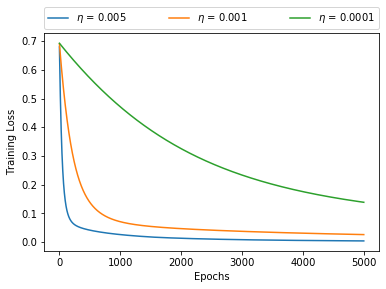

In [12]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#flatten x matrix from 28x28 to 784x1 vector and add bias to each input set
x_train = [k.flatten() for k in trainData]
x_train = np.hstack( (np.vstack(np.ones(len(x_train))), x_train) )
x_test = [k.flatten() for k in testData]
x_test = np.hstack( (np.vstack(np.ones(len(x_test))), x_test) )


#Create Weight Vector
w = np.zeros(len(x_train[0]))
w1, err1 = grad_descent(w, x_train, trainTarget, 0.005, 5000, 0, 10**-7)
w2, err2 = grad_descent(w, x_train, trainTarget, 0.001, 5000, 0, 10**-7)
w3, err3 = grad_descent(w, x_train, trainTarget, 0.0001, 5000, 0, 10**-7)

plt.plot(err1, label='$\eta$ = 0.005');
plt.plot(err2, label='$\eta$ = 0.001');
plt.plot(err3, label='$\eta$ = 0.0001');
plt.ylabel('Training Loss');
plt.xlabel('Epochs');
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

print('Test Loss for \u03B7 = 0.005: ', crossEntropyLoss(w1, x_test, testTarget, 0))
print('Test Loss for \u03B7 = 0.001: ', crossEntropyLoss(w2, x_test, testTarget, 0))
print('Test Loss for \u03B7 = 0.0001: ', crossEntropyLoss(w3, x_test, testTarget, 0))


Briefly discuss the impact of $\eta$ on the training time. 

When increased, $\eta$ was observed to shorten the training time. Higher values of $\eta$ increase the change in $\underline w$ each update as it trends towards the minima. This in turn reduces the number of epochs required to reach an acceptable minima for the training set. 

Note, increasing $\eta$ too much may cause the regression to overshoot the minima and oscillate with an unfavorable magnitude. Lowering this value too much will take longer to solve. 

$\eta = 0.001$ apeared to be a sweet-spot for training the weights, producing the lowest cross-entropy loss in the test set after 5000 iterations. This implies the weights generalized better (without addition of the generalization term) than $\eta = 0.005$ and $\eta = 0.0001$. $\eta = 0.0001$ still had a high training loss after 5000 iterations, thus did not converge to a good solution compared to $\eta = 0.001$

### Generalization [3 points]:
Fix the learning rate to $\eta=0.005$, and consider values for the regularization parameter $\lambda = 0.001,\, 0.01,\, 0.1$. Measure the validation and test losses and state them in your answer below. Comment on the effect of regularization on performance as well as the rationale behind tuning $\eta$ using the validation set.

(Note, the question above asks to comment on the effect of $\eta$. This should ask to comment on $\lambda$, which has been done below.) 

The following table summarizes the validation and test data errors as the three tested values of $\lambda$. Rather, this is the classification accruacy obntained by computing the cross-entropy-loss for the test and validation data using weights trained with the training data suing varied regularization rates. The cross-entropy loss does not use the regularization for the test and validation data errors. 

$$
\begin{array} {|r|r|}\hline \lambda & Validation\ Data & Test\ Data \\ \hline 0.0 & 0.1731 & 0.1503 \\ \hline 0.001 & 0.0974 & 0.0893 \\ \hline 0.01 & 0.0918 & 0.0861 \\ \hline 0.1 & 0.1100 & 0.0989 \\ \hline  \end{array}
$$

Tuning the regularization parameter $\lambda$ optimizes the weights by solving the problem of overfitting. Overfitting implies the weights are trained to best fit the training set, but do not generalize well to create the best solution for all possible datasets. Tuning $\lambda$ finds the best regularization value to suit all data. 

$\lambda$ cab be optimized by observing error in the validation set as well as the training error during training. Overfitting can be observed during the training process by checking the validation dataset errors. If the validation error increases while training error decreases, overfitting may be occurring. A properly tuned $\lambda$ will ensure both the training and validation errors decrease during training. 

When training is complete, the weights will be biased to fit both the training and validation dataset. The test set is used independenly of all hyperparameter tuning to assess the error of the trained weights. 

In this experiment, a sweet spot was observed in selecting $\lambda$ as seen in the table above. $\lambda = 0.01$ generalized the training data to best fit the validation and test set better than $\lambda = 0.001$ and $\lambda = 0.1$. Less regularization will trend to overfitting the data. Too much regularization may overgeneralize the weights so that they do not provide the lowest average error for all possible data. 


